In [1]:
!pip install tensorflow==2.1

ERROR: Could not find a version that satisfies the requirement tensorflow==2.1 (from versions: 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.13.1, 2.14.0rc0, 2.14.0rc1, 2.14.0, 2.14.1, 2.15.0rc0, 2.15.0rc1, 2.15.0, 2.15.1, 2.16.0rc0, 2.16.1)
ERROR: No matching distribution found for tensorflow==2.1


In [2]:
!pip install -q efficientnet

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import scipy.io
import tarfile
import csv
import sys
import os


import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.models as M
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
import tensorflow.keras.callbacks as C
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping
from tensorflow.keras.callbacks import Callback
from tensorflow.keras import optimizers
import efficientnet.tfkeras as efn

from sklearn.model_selection import train_test_split

import PIL
from PIL import ImageOps, ImageFilter
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
%matplotlib inline



In [4]:
EPOCHS               = 5
BATCH_SIZE           = 8
LR                   = 1e-3
VAL_SPLIT            = 0.2

CLASS_NUM            = 102
IMG_SIZE             = 250
IMG_CHANNELS         = 3
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

DATA_PATH = '102flowers.tgz'
PATH = "flower/"

In [5]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)  
PYTHONHASHSEED = 0

# Data

In [6]:
def get_all_filenames(tar_fn):
    with tarfile.open(tar_fn) as f:
        return [m.name for m in f.getmembers() if m.isfile()]

df = pd.DataFrame()
df['Id'] = sorted(get_all_filenames("102flowers.tgz"))
df['Category'] = scipy.io.loadmat('imagelabels.mat')['labels'][0] - 1
df['Category'] = df['Category'].astype(str)

In [7]:
df.head(5)

,Id,Category
0,jpg/image_00001.jpg,76
1,jpg/image_00002.jpg,76
2,jpg/image_00003.jpg,76
3,jpg/image_00004.jpg,76
4,jpg/image_00005.jpg,76


In [8]:
df['Category'].value_counts()

Category
50    258
76    251
45    196
72    194
88    184
     ... 
6      40
44     40
33     40
0      40
26     40
Name: count, Length: 102, dtype: int64

In [9]:
df['Category'].nunique()

102

 ## Stratify Split

In [10]:
train_files, test_files, train_labels, test_labels = \
    train_test_split(df['Id'], df['Category'], test_size=0.2, random_state=42, stratify=df['Category'])

train_files = pd.DataFrame(train_files)
test_files = pd.DataFrame(test_files)
train_files['Category'] = train_labels
test_files['Category'] = test_labels

train_files.shape, test_files.shape

((6551, 2), (1638, 2))

In [11]:
train_files.head(5)

,Id,Category
2361,jpg/image_02362.jpg,42
512,jpg/image_00513.jpg,87
5969,jpg/image_05970.jpg,68
6251,jpg/image_06252.jpg,60
516,jpg/image_00517.jpg,87


In [12]:
train_files['Category'].value_counts()

Category
50    206
76    201
45    157
72    155
88    147
     ... 
0      32
6      32
33     32
2      32
26     32
Name: count, Length: 102, dtype: int64

In [13]:
test_files['Category'].value_counts()

Category
50    52
76    50
72    39
45    39
88    37
      ..
78     8
0      8
20     8
24     8
66     8
Name: count, Length: 102, dtype: int64

### Data augmentation

In [14]:
test_datagen = ImageDataGenerator(rescale=1. / 255)

### datagen

In [15]:
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_files,
    directory=PATH,
    x_col="Id",
    y_col="Category",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False, 
    seed=RANDOM_SEED,)

Found 1638 validated image filenames belonging to 102 classes.


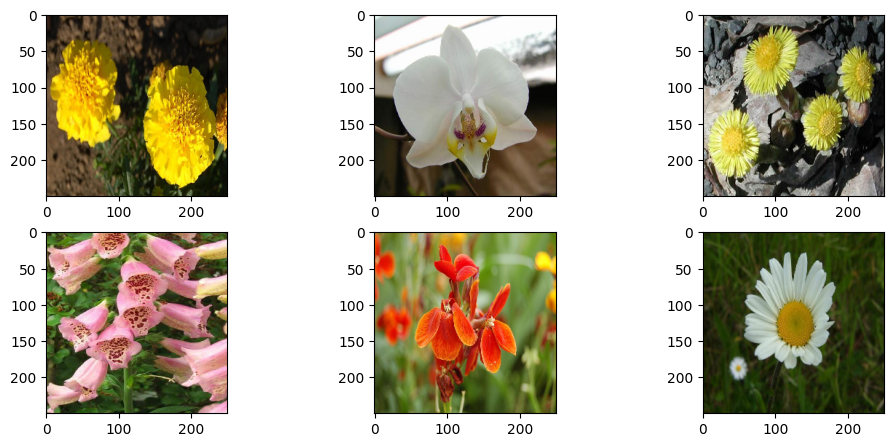

In [16]:
x,y = test_generator.next()
plt.figure(figsize=(12,8))

for i in range(0,6):
    image = x[i]
    plt.subplot(3,3, i+1)
    plt.imshow(image)
    #plt.title('Class: '+str(y[i]))
    #plt.axis('off')
plt.show()

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate predictions on the test data
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('best_model.hdf5')
predictions = model.predict_generator(test_generator)
predicted_labels = np.argmax(predictions, axis=1)

# True labels
true_labels = test_generator.classes




C:\Users\ganesh\AppData\Local\Temp\ipykernel_14572\910330495.py:11: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(test_generator)


In [18]:
# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)



In [19]:
# Visualize confusion matrix
plt.figure(figsize=(102,102))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices, yticklabels=test_generator.class_indices)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')  # Save the confusion matrix visualization to a file
plt.show()

In [20]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)

# Calculate precision
precision = precision_score(true_labels, predicted_labels, average='weighted')

# Calculate recall
recall = recall_score(true_labels, predicted_labels, average='weighted')

# Calculate F1-score
f1 = f1_score(true_labels, predicted_labels, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.9407814407814408
Precision: 0.9496807815123383
Recall: 0.9407814407814408
F1-score: 0.9405658650950488


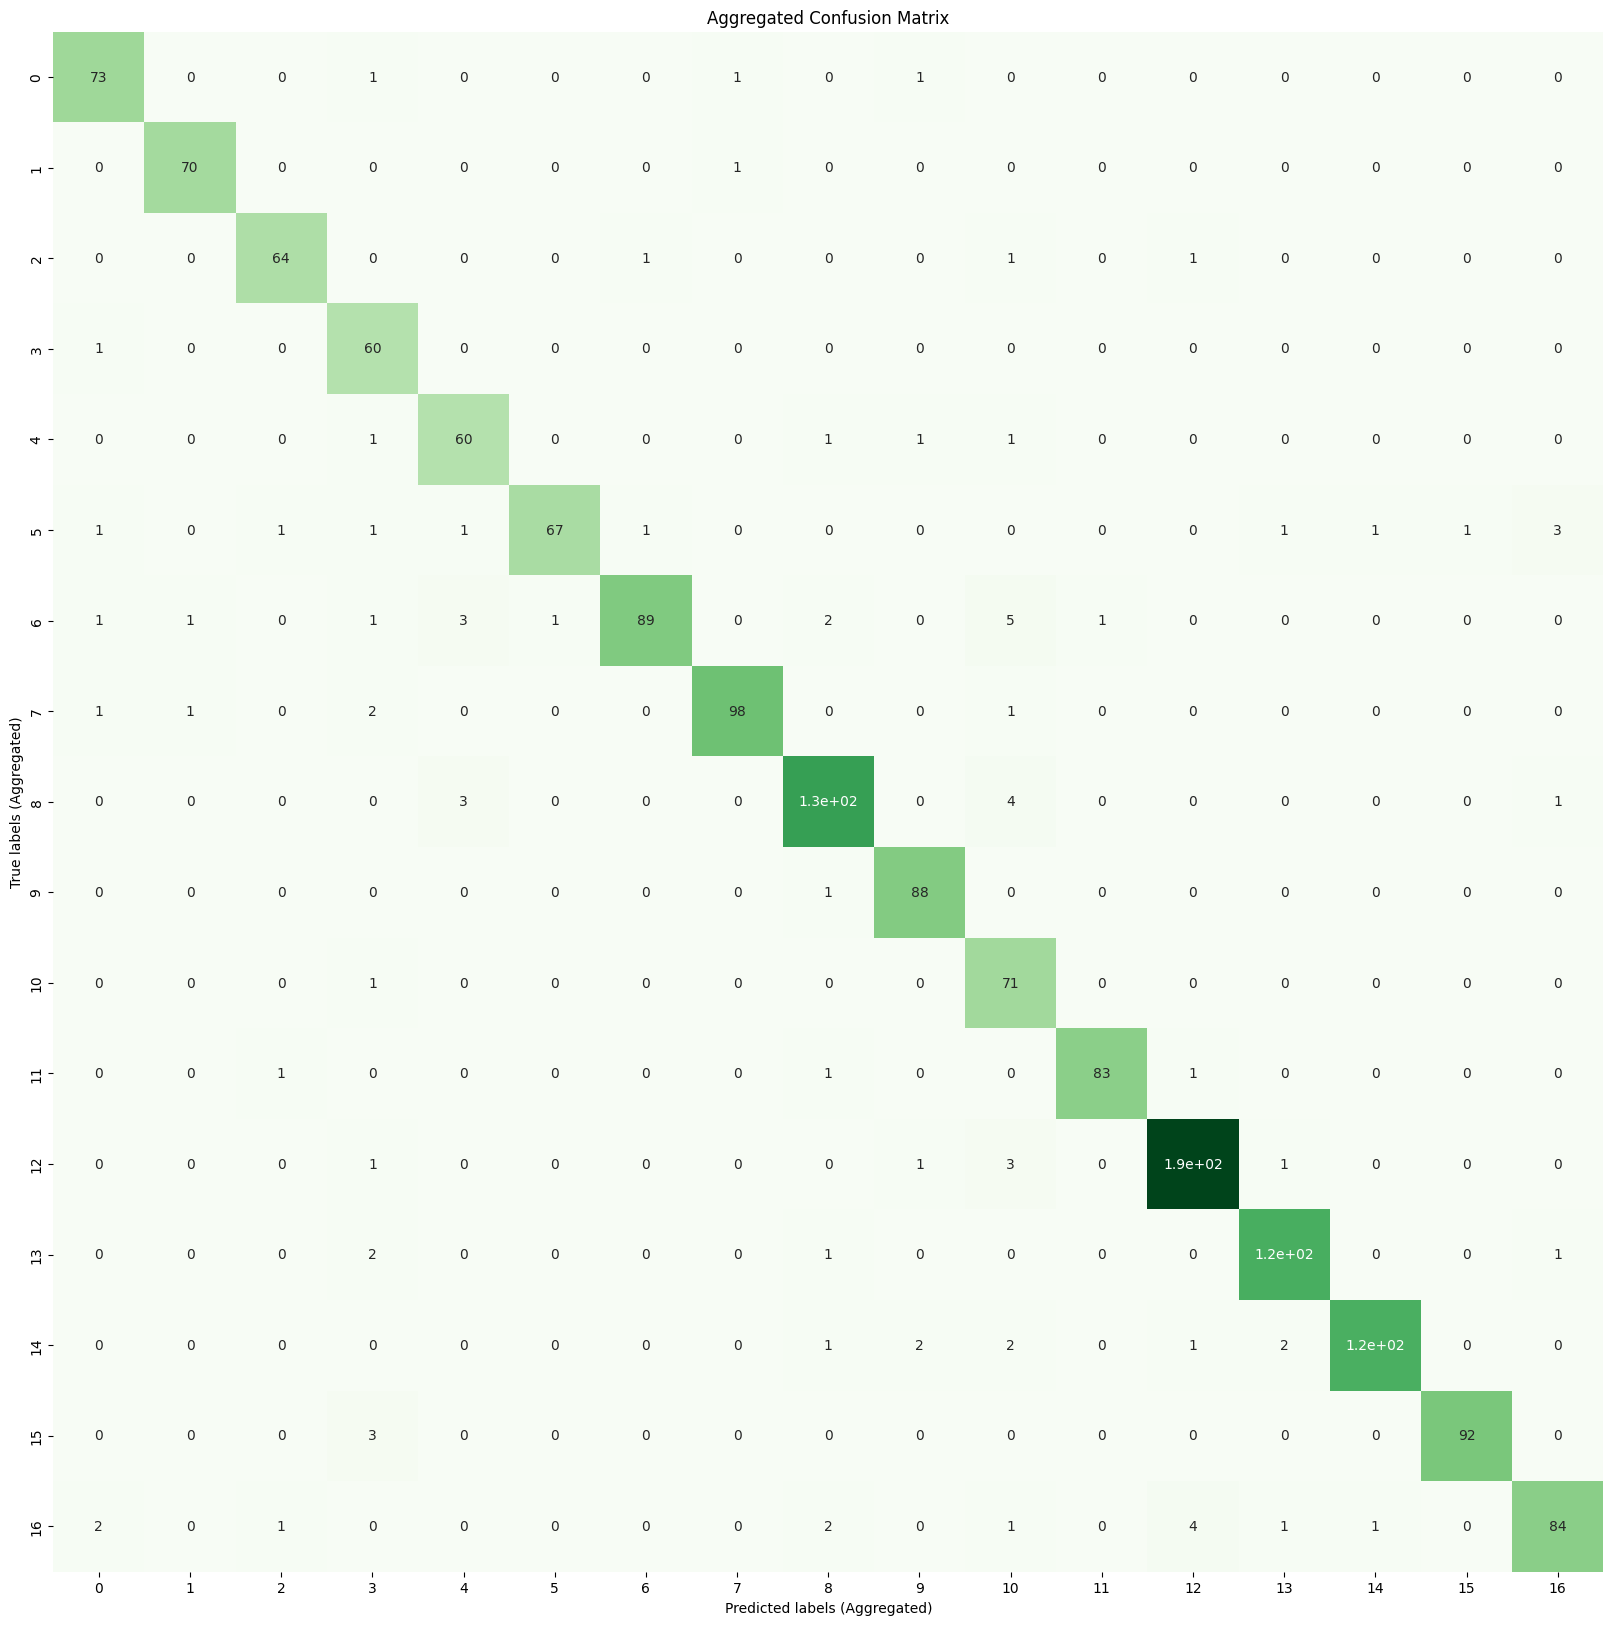

In [30]:
cm_size=102
subset_size=6

aggregated_cm_size = int(cm_size / subset_size)
aggregated_cm = np.zeros((aggregated_cm_size, aggregated_cm_size))

for i in range(0, cm_size, subset_size):
    for j in range(0, cm_size, subset_size):
        subset = cm[i:i+subset_size, j:j+subset_size]
        aggregated_cm[int(i/subset_size), int(j/subset_size)] = np.sum(subset)

plt.figure(figsize=(20,20))
sns.heatmap(aggregated_cm, annot=True, cmap='Greens', cbar=False)
plt.xlabel('Predicted labels (Aggregated)')
plt.ylabel('True labels (Aggregated)')
plt.title('Aggregated Confusion Matrix')
plt.show()